# Perform face classification using VGGface

## 1. First resolving version conflict of the default vggface package

In [68]:
# Resolve version conflict from one of the files
filename = "/home/eric/anaconda3/envs/peekingduckling/lib/python3.8/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

20951

In [72]:
%load_ext autoreload
%autoreload 2

In [196]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import numpy as np
from numpy import asarray
from PIL import Image
import pickle
import tensorflow as tf
from tensorflow import keras
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import os
sys.path.append(Path(os.getcwd()).parent.absolute())
from src.datapipeline.images_to_embeddings import Create_Embeddings
from src.modelling.vggface_model import VGGFace_Model
from src.modelling.knn_model import KNN_Classify

## 2. Download base model

In [34]:
# Loading VGGFace model without classifier and getting output to be a face embedding
base_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
# summarize input and output shape
print('Inputs: %s' % base_model.inputs)
print('Outputs: %s' % base_model.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_6')>]
Outputs: [<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d_3')>]


## 3. Obtain image embeddings

In [35]:
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(files, model):
	# extract faces
	faces = [f for f in files]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)
	# create a vggface model
	# perform prediction
	yhat = model.predict(samples)
	return yhat

In [36]:
model = keras.Sequential([
    keras.layers.Resizing(224,224),
    # keras.layers.RandomZoom((-0.2, 0.2), fill_mode='reflect'),
    # keras.layers.RandomTranslation(0.2, 0.2, fill_mode='reflect'),
    # keras.layers.RandomRotation(0.2, fill_mode='reflect'),
    # keras.layers.RandomFlip(),
    # keras.layers.RandomContrast(0.2),
    base_model,
])

## 4. Compare image embeddings between two different person

In [59]:
image_path = '../data/raw/images/clarence/300_clarence.jpg'
img = Image.open(image_path)

In [60]:
img = np.array(img)
clarence_embedding = get_embeddings([img], model)

In [61]:
clarence_embedding

array([[0.7209997 , 0.        , 0.03487726, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [62]:
image_path = '../data/raw/images/eric_kwok/0_eric_kwok.jpg'
img = Image.open(image_path)

In [63]:
img = np.array(img)
kwok_embedding = get_embeddings([img], model)

In [64]:
kwok_embedding

array([[2.646888 , 0.0573287, 0.       , ..., 5.8668456, 0.       ,
        0.       ]], dtype=float32)

In [65]:
# Comparison of embedding using euclidean distance
diff_dist = np.linalg.norm(clarence_embedding-kwok_embedding)
diff_dist

101.5161

In [66]:
# Comparring using cosine difference (1 - cosine distance)
cos_sim = cosine(clarence_embedding, kwok_embedding)
cos_sim

0.576074093580246

## 5. Compare embeddings for the same person

In [57]:
image_path = '../data/raw/images/clarence/300_clarence.jpg'
img = Image.open(image_path)

img = np.array(img)
clarence_embedding_2 = get_embeddings([img], model)

# Comparison of embedding
diff_dist = np.linalg.norm(clarence_embedding-clarence_embedding_2)
diff_dist

88.50315

In [58]:
# Comparring using cosine distance (1 - cosine similarity)
cos_sim = cosine(clarence_embedding, clarence_embedding_2)
cos_sim

0.46248912811279297

## 6. Get the embeddings from clarence, eric kwok and eric lee

In [112]:
embedding_path = '../data/embedding.pickle'
with open(embedding_path, 'rb') as f:
    embedding_dict = pickle.load(f)

In [113]:
len(embedding_dict['embedding'])

1900

In [114]:
embedding_dict.keys()

dict_keys(['embedding', 'class'])

In [115]:
X = normalize(embedding_dict['embedding'], norm='l2', axis=1, copy=True)
y = embedding_dict['class']

In [116]:
pca = PCA()
pca.fit(X)

PCA()

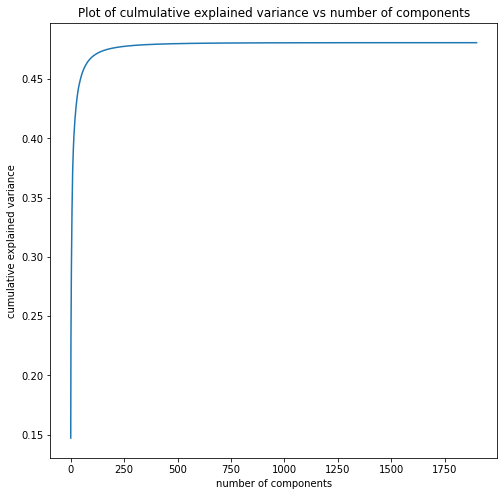

In [117]:
plt.figure(figsize=(8,8))
plt.plot(np.cumsum(pca.explained_variance_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title("Plot of culmulative explained variance vs number of components")
plt.show()

In [118]:
X_trans = pca.transform(X)

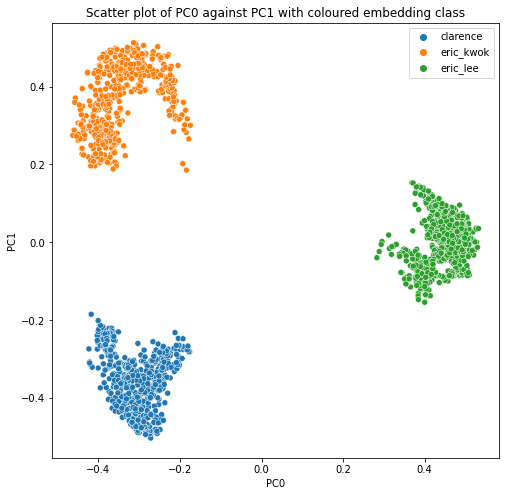

In [120]:
 # Draw scatterplot 
plt.figure(figsize=(8,8))
plt.title("Scatter plot of PC0 against PC1 with coloured embedding class")
plt.xlabel("PC0")
plt.ylabel("PC1")
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y)
current_handles, current_labels = plt.gca().get_legend_handles_labels()
plt.legend(current_handles, ["{}".format(i) for i in current_labels])
plt.show()

## 7. Testing of KNN for prediction

In [124]:
knn = KNeighborsClassifier(1, metric='euclidean', n_jobs=-1)
knn.fit(embedding_dict['embedding'], embedding_dict['class'])

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=1)

### 7.1 Create embeddings for validation images

In [ ]:
CE = Create_Embeddings()
CE.load_images_paths('../data/raw/output/val')

In [148]:
model_folder_path = '../models/base_model.pickle'
VGG_M = VGGFace_Model(model_path=model_folder_path)
model = VGG_M.build_model()

In [152]:
embedding_dict = CE.build_embedding_db(model)

embeddding progress: 100%|██████████| 13570/13570 [13:16<00:00, 17.04it/s]


In [208]:
knn_path = '../models/knn.pickle'
embedding_path = '../data/embedding.pickle'
knn = KNN_Classify(embedding_path, knn_path)

In [227]:
knn.build_model(fit_knn=True)

In [228]:
y_pred, prob = knn.predict(embedding_dict['embedding'], threshold=0.4)

In [229]:
print(f"Accuracy score: {accuracy_score(embedding_dict['class'], y_pred)}")

Accuracy score: 0.749521002210759


In [230]:
onehot = OneHotEncoder(sparse=False)
y_true_oh = onehot.fit_transform(np.array(embedding_dict['class']).reshape(-1,1))
y_pred_oh = onehot.transform(y_pred.reshape(-1,1))
f1_score(y_true_oh, y_pred_oh, average=None)
print(f"F1 score: {f1_score(y_true_oh, y_pred_oh, average='samples')}")

F1 score: 0.749521002210759


In [231]:
f1_score(y_true_oh, y_pred_oh, average=None)

array([0.05637813, 0.95027624, 0.63106796, 0.85374984])

In [232]:
X = normalize(embedding_dict['embedding'], norm='l2', axis=1, copy=True)
y = embedding_dict['class']

In [233]:
pca.fit(X)

PCA()

In [234]:
X_trans = pca.transform(X)

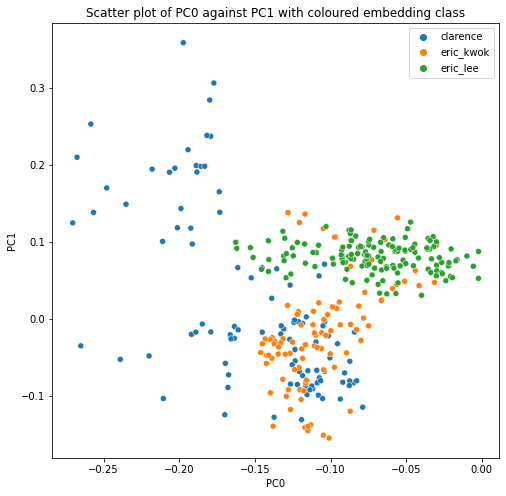

In [240]:
 # Draw scatterplot 
plt.figure(figsize=(8,8))
plt.title("Scatter plot of PC0 against PC1 with coloured embedding class")
plt.xlabel("PC0")
plt.ylabel("PC1")
y = np.array(y)
sns.scatterplot(x=X_trans[y!='others',0], y=X_trans[y!='others',1], hue=y[y!='others'])
current_handles, current_labels = plt.gca().get_legend_handles_labels()
plt.legend(current_handles, ["{}".format(i) for i in current_labels])
plt.show()

In [239]:
X_trans

array([[-1.91387143e-01,  9.69241020e-02, -1.95631078e-01, ...,
        -1.61583766e-04,  1.99330182e-04,  1.81414094e-04],
       [-1.73210095e-01,  1.38238844e-01, -2.45158351e-01, ...,
        -8.26814323e-04,  4.66898418e-04, -8.04076984e-05],
       [-1.73547771e-01,  1.64759335e-01, -2.51113435e-01, ...,
        -7.35478598e-04,  9.85844890e-04,  1.96689583e-04],
       ...,
       [-1.92801784e-01,  1.63303455e-01,  1.49469397e-01, ...,
        -8.56424461e-04,  4.47481878e-04,  6.11409176e-05],
       [ 2.46602479e-01,  9.99094695e-02,  7.31549587e-02, ...,
        -3.45986253e-04, -4.68815119e-04,  4.05997454e-04],
       [-9.59394884e-02,  3.12898917e-01, -8.19292135e-02, ...,
        -3.70104655e-04,  4.31597828e-05, -8.88404150e-05]])